In [5]:
%env SM_FRAMEWORK=tf.keras
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
import glob

from keras.utils import normalize
from keras.metrics import MeanIoU


env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
pip install segmentation-models

     |████████████████████████████████| 51kB 8.5MB/s 


In [13]:
SIZE_X = 128 
SIZE_Y = 128
n_classes=4

In [7]:
train_images = []
for directory_path in glob.glob("/content/drive/MyDrive/building Masks/src/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 1)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)

In [8]:
train_masks = [] 
for directory_path in glob.glob("/content/drive/MyDrive/building Masks/label/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)

In [17]:
len(train_images),len(train_masks)

(3370, 3370)

In [16]:
train_images=train_images[:3370]

In [18]:
train_images = np.array(train_images)
train_masks = np.array(train_masks)

In [19]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
np.unique(train_masks_encoded_original_shape)

array([0, 1, 2, 3])

In [21]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test,  y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

In [23]:
X_train.shape, X_test.shape,  y_train.shape, y_test.shape

((3033, 128, 128, 3),
 (337, 128, 128, 3),
 (3033, 128, 128, 1),
 (337, 128, 128, 1))

In [24]:
print("Class values in the dataset are ... ", np.unique(y_train))

Class values in the dataset are ...  [0 1 2 3]


In [25]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

In [26]:
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [27]:
n_classes=4
activation='softmax'

In [28]:
LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [29]:
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [30]:
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [31]:
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

In [32]:
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

In [33]:
model1 = sm.Unet(BACKBONE1, classes=n_classes, activation=activation)
model1.compile(optim, total_loss, metrics=metrics)
model1.summary()
history1=model1.fit(X_train1, y_train_cat,batch_size=8, epochs=50,verbose=1,validation_data=(X_test1, y_test_cat))

85524480/85521592 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
___________________________

In [34]:
model1.save('res34_backbone_50epochs.h5')

In [35]:
BACKBONE2 = 'inceptionv3'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

In [37]:
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

In [38]:
model2 = sm.Unet(BACKBONE2, classes=n_classes, activation=activation)
model2.compile(optim, total_loss, metrics)
model2.summary()
history2=model2.fit(X_train2, y_train_cat,batch_size=8, epochs=50,verbose=1,validation_data=(X_test2, y_test_cat))

87916544/87910968 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
___________________________

In [40]:
model2.save('inceptionv3_backbone_50epochs.h5')

RuntimeError: ignored

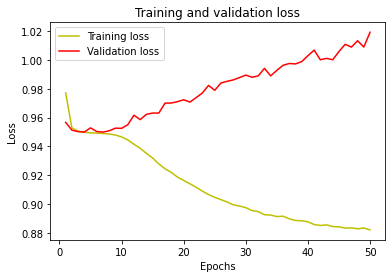

In [41]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

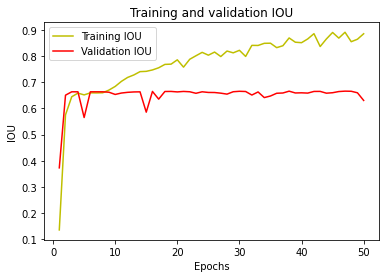

In [42]:
acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [43]:
y_pred1=model2.predict(X_test2)
y_pred1_argmax=np.argmax(y_pred1, axis=3)

In [44]:
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.19679962
